# WebGazer vs DenseNet Model Comparison

This notebook implements a WebGazer-style ridge regression algorithm on raw pixel data and compares its performance with the existing DenseNet-based eye tracking model on the same dataset.

## Setup and Imports

In [ ]:
!pip install osfclient --quiet
!pip install keras_cv --quiet
!pip install plotnine --quiet
!pip install wandb --quiet
!pip install keras-hub --quiet
!pip install dotenv --quiet
!pip install scikit-learn --quiet

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy import stats

import keras
from keras import ops
import keras_hub

import osfclient
from osfclient.api import OSF

import wandb
from wandb.integration.keras import WandbMetricsLogger

from plotnine import ggplot, geom_point, aes, geom_line, geom_histogram, geom_boxplot, geom_ribbon, scale_y_reverse, scale_y_continuous, theme_void, scale_x_continuous, scale_color_manual, scale_fill_manual, ylab, xlab, labs, theme, theme_classic, element_text, element_blank, element_line, facet_wrap, geom_abline, geom_smooth, stat_smooth

In [ ]:
try:
  from google.colab import userdata
  IN_COLAB = True
except ImportError:
  IN_COLAB = False

In [ ]:
!pip install git+https://github.com/jspsych/eyetracking-utils.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import et_util.dataset_utils as dataset_utils
import et_util.embedding_preprocessing as embed_pre
import et_util.model_layers as model_layers
from et_util import experiment_utils
from et_util.custom_loss import normalized_weighted_euc_dist
from et_util.model_analysis import plot_model_performance

In [ ]:
if IN_COLAB:
    os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')
    os.environ['OSF_TOKEN'] = userdata.get('osftoken')
    os.environ['OSF_USERNAME'] = userdata.get('osfusername')
else:
    # Load from a .env file using python-dotenv
    from dotenv import load_dotenv
    load_dotenv()
    os.environ['WANDB_API_KEY'] = os.getenv('WANDB_API_KEY', '')
    os.environ['OSF_TOKEN'] = os.getenv('OSF_TOKEN', '')
    os.environ['OSF_USERNAME'] = os.getenv('OSF_USERNAME', '')

os.environ['OSF_ANALYSIS_PROJECT_ID'] = "8ecx5"
os.environ["KERAS_BACKEND"] = "tensorflow"

## Constants and Configuration

In [ ]:
# Fixed constants
MAX_TARGETS = 288
IMAGE_HEIGHT = 36
IMAGE_WIDTH = 144
IMAGE_PIXELS = IMAGE_HEIGHT * IMAGE_WIDTH  # 5,184 pixels

# Model configuration (from existing analysis)
EMBEDDING_DIM = 200
RIDGE_REGULARIZATION = 0.001
BACKBONE = "densenet"

# Experiment configuration
EXPERIMENT_ID = "gf1zjs9v"
ENTITY_NAME = "vassar-cogsci-lab"
PROJECT_NAME = "eye-tracking-dense-full-data-set-single-eye"

## Dataset Loading and Preprocessing

Reusing the exact same dataset loading pipeline from the original analysis to ensure fair comparison.

In [ ]:
!osf -p uf2sh fetch single_eye_tfrecords.tar.gz

100% 675M/675M [00:04<00:00, 160Mbytes/s]


In [ ]:
!mkdir single_eye_tfrecords
!tar -xf single_eye_tfrecords.tar.gz -C single_eye_tfrecords

In [ ]:
def parse(element):
    """Parse TensorFlow record - same as original analysis"""
    data_structure = {
        'landmarks': tf.io.FixedLenFeature([], tf.string),
        'img_width': tf.io.FixedLenFeature([], tf.int64),
        'img_height': tf.io.FixedLenFeature([], tf.int64),
        'x': tf.io.FixedLenFeature([], tf.float32),
        'y': tf.io.FixedLenFeature([], tf.float32),
        'eye_img': tf.io.FixedLenFeature([], tf.string),
        'phase': tf.io.FixedLenFeature([], tf.int64),
        'subject_id': tf.io.FixedLenFeature([], tf.int64),
    }

    content = tf.io.parse_single_example(element, data_structure)

    raw_image = content['eye_img']
    width = content['img_width']
    height = content['img_height']
    phase = content['phase']
    depth = 3
    coords = [content['x'], content['y']]
    subject_id = content['subject_id']

    image = tf.io.parse_tensor(raw_image, out_type=tf.uint8)

    return image, phase, coords, subject_id

In [ ]:
# Load the dataset
test_data, _, _ = dataset_utils.process_tfr_to_tfds(
    'single_eye_tfrecords/',
    parse,
    train_split=1.0,
    val_split=0.0,
    test_split=0.0,
    random_seed=12604,
    group_function=lambda img, phase, coords, subject_id: subject_id
)

In [ ]:
def rescale_coords_map(img, phase, coords, id):
    """Rescale coordinates from 0-100 to 0-1 range"""
    return img, phase, tf.divide(coords, tf.constant([100.])), id

test_data_rescaled = test_data.map(rescale_coords_map)

In [ ]:
# Define calibration points (same as original analysis)
cal_points = tf.constant([
    [5, 5],
    [5, 27.5],
    [5, 50],
    [5, 72.5],
    [5, 95],
    [35, 5],
    [35, 27.5],
    [35, 50],
    [35, 72.5],
    [35, 95],
    [65, 5],
    [65, 27.5],
    [65, 50],
    [65, 72.5],
    [65, 95],
    [95, 5],
    [95, 27.5],
    [95, 50],
    [95, 72.5],
    [95, 95],
], dtype=tf.float32)

scaled_cal_points = tf.divide(cal_points, tf.constant([100.]))

## WebGazer Implementation

Implementing the WebGazer algorithm: ridge regression on raw pixel intensities.

In [ ]:
class WebGazerModel:
    """
    WebGazer-style ridge regression model that operates directly on raw pixel intensities.
    Implements the same interface as the DenseNet model for fair comparison.
    """

    def __init__(self, lambda_ridge=0.001, normalize_pixels=True):
        self.lambda_ridge = lambda_ridge
        self.normalize_pixels = normalize_pixels
        self.ridge_x = Ridge(alpha=lambda_ridge, fit_intercept=True)
        self.ridge_y = Ridge(alpha=lambda_ridge, fit_intercept=True)
        self.is_fitted = False

    def _preprocess_images(self, images):
        """
        Preprocess images: flatten and optionally normalize.
        Args:
            images: numpy array of shape [n_samples, height, width] or [n_samples, height, width, 1]
        Returns:
            Flattened and preprocessed images of shape [n_samples, height*width]
        """
        # Ensure we have the right shape
        if len(images.shape) == 4 and images.shape[-1] == 1:
            images = np.squeeze(images, axis=-1)  # Remove channel dimension

        # Flatten images
        n_samples = images.shape[0]
        flattened = images.reshape(n_samples, -1)

        # Normalize pixels to 0-1 range if specified
        if self.normalize_pixels:
            flattened = flattened.astype(np.float32) / 255.0

        return flattened

    def fit(self, images, coordinates, sample_weights=None):
        """
        Fit the WebGazer model to calibration data.
        Args:
            images: calibration images [n_cal_samples, height, width]
            coordinates: gaze coordinates [n_cal_samples, 2]
            sample_weights: optional sample weights [n_cal_samples]
        """
        X = self._preprocess_images(images)

        # Fit separate ridge regression models for x and y coordinates
        self.ridge_x.fit(X, coordinates[:, 0], sample_weight=sample_weights)
        self.ridge_y.fit(X, coordinates[:, 1], sample_weight=sample_weights)

        self.is_fitted = True

    def predict(self, images):
        """
        Predict gaze coordinates for test images.
        Args:
            images: test images [n_test_samples, height, width]
        Returns:
            predicted coordinates [n_test_samples, 2]
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        X = self._preprocess_images(images)

        # Predict x and y coordinates separately
        pred_x = self.ridge_x.predict(X)
        pred_y = self.ridge_y.predict(X)

        # Combine predictions
        predictions = np.column_stack([pred_x, pred_y])

        return predictions

    def get_params(self):
        """Return model parameters for logging/analysis."""
        return {
            'lambda_ridge': self.lambda_ridge,
            'normalize_pixels': self.normalize_pixels,
            'n_features': IMAGE_PIXELS,
            'model_type': 'WebGazer_RidgeRegression'
        }

## Data Processing for Model Comparison

Creating functions to process the dataset for both models using identical train/test splits.

In [ ]:
def prepare_masked_dataset(dataset, calibration_points=None, cal_phase=None):
    """Prepare masked dataset - same as original analysis"""
    def group_by_subject(subject_id, ds):
        return ds.batch(batch_size=MAX_TARGETS)

    grouped_dataset = dataset.group_by_window(
        key_func=lambda img, phase, coords, subject_id: subject_id,
        reduce_func=group_by_subject,
        window_size=MAX_TARGETS
    )

    def add_masks_to_batch(images, phase, coords, subject_ids):
        actual_batch_size = tf.shape(images)[0]

        # Create phase masks
        phase1_mask = tf.cast(tf.equal(phase, 1), tf.int8)
        phase2_mask = tf.cast(tf.equal(phase, 2), tf.int8)

        cal_mask = tf.zeros(actual_batch_size, dtype=tf.int8)
        target_mask = tf.zeros(actual_batch_size, dtype=tf.int8)

        if calibration_points is None:
            raise ValueError("Need to specify calibration points in test mode")
        else:
            coords_xpand = tf.expand_dims(coords, axis=1)
            cal_xpand = tf.expand_dims(calibration_points, axis=0)

            # Check which points match calibration points
            equality = tf.equal(coords_xpand, cal_xpand)
            matches = tf.reduce_all(equality, axis=-1)
            point_matches = tf.reduce_any(matches, axis=1)
            cal_mask = tf.cast(point_matches, dtype=tf.int8)

        target_mask = (1 - cal_mask) * phase2_mask

        if cal_phase == 1:
            cal_mask = cal_mask * phase1_mask
        elif cal_phase == 2:
            cal_mask = cal_mask * phase2_mask

        padded_images = tf.pad(
            tf.reshape(images, (-1, 36, 144, 1)),
            [[0, MAX_TARGETS - actual_batch_size], [0, 0], [0, 0], [0, 0]]
        )
        padded_coords = tf.pad(
            coords,
            [[0, MAX_TARGETS - actual_batch_size], [0, 0]]
        )
        padded_cal_mask = tf.pad(
            cal_mask,
            [[0, MAX_TARGETS - actual_batch_size]]
        )
        padded_target_mask = tf.pad(
            target_mask,
            [[0, MAX_TARGETS - actual_batch_size]]
        )

        padded_images = tf.ensure_shape(padded_images, [MAX_TARGETS, 36, 144, 1])
        padded_coords = tf.ensure_shape(padded_coords, [MAX_TARGETS, 2])
        padded_cal_mask = tf.ensure_shape(padded_cal_mask, [MAX_TARGETS])
        padded_target_mask = tf.ensure_shape(padded_target_mask, [MAX_TARGETS])

        return (padded_images, padded_coords, padded_cal_mask, padded_target_mask), padded_coords, subject_ids[0]

    masked_dataset = grouped_dataset.map(
        lambda imgs, phase, coords, subj_ids: add_masks_to_batch(imgs, phase, coords, subj_ids),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return masked_dataset

In [ ]:
def extract_calibration_and_test_data(masked_dataset):
    """
    Extract calibration and test data from masked dataset for model training/evaluation.
    Returns data in format suitable for both WebGazer and DenseNet models.
    """
    subject_data = []

    for batch in masked_dataset.as_numpy_iterator():
        features, labels, subject_id = batch
        images, coords, cal_mask, target_mask = features

        # Extract calibration data (where cal_mask == 1)
        cal_indices = np.where(cal_mask == 1)[0]
        cal_images = images[cal_indices]
        cal_coords = coords[cal_indices]

        # Extract test data (where target_mask == 1)
        test_indices = np.where(target_mask == 1)[0]
        test_images = images[test_indices]
        test_coords = coords[test_indices]

        # Only include subjects with sufficient data
        if len(cal_indices) >= 10 and len(test_indices) >= 96:
            subject_data.append({
                'subject_id': subject_id,
                'cal_images': cal_images,
                'cal_coords': cal_coords,
                'test_images': test_images,
                'test_coords': test_coords
            })

    return subject_data

In [ ]:
# Prepare the dataset with Phase 1 calibration
print("Preparing masked dataset with Phase 1 calibration...")
masked_dataset_p1 = prepare_masked_dataset(test_data_rescaled, scaled_cal_points, 1)

# Extract subject data for model comparison
print("Extracting calibration and test data...")
subject_dataset = extract_calibration_and_test_data(masked_dataset_p1)

print(f"Prepared data for {len(subject_dataset)} subjects")
print(f"Sample subject - Cal images: {subject_dataset[0]['cal_images'].shape}, Test images: {subject_dataset[0]['test_images'].shape}")

Preparing masked dataset with Phase 1 calibration...
Extracting calibration and test data...
Prepared data for 224 subjects
Sample subject - Cal images: (20, 36, 144, 1), Test images: (124, 36, 144, 1)


## Load Existing DenseNet Model

Loading the pre-trained DenseNet model for comparison.

In [ ]:
# Download and load the existing model weights
wandb.login()
api = wandb.Api()
run = api.run(f"{ENTITY_NAME}/{PROJECT_NAME}/{EXPERIMENT_ID}")
config = run.config
run.file("full_model.weights.h5").download(exist_ok=True)

print("Model configuration:")
print(f"Embedding dim: {config['embedding_dim']}")
print(f"Ridge regularization: {config['ridge_regularization']}")
print(f"Backbone: {config['backbone']}")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Model configuration:
Embedding dim: 200
Ridge regularization: 0.1
Backbone: densenet


In [ ]:
# Recreate the existing model architecture (copied from original analysis)

class SimpleTimeDistributed(keras.layers.Wrapper):
    def __init__(self, layer, **kwargs):
        super().__init__(layer, **kwargs)
        self.supports_masking = getattr(layer, 'supports_masking', False)

    def build(self, input_shape):
        if not isinstance(input_shape, (tuple, list)) or len(input_shape) < 3:
            raise ValueError(
                "`SimpleTimeDistributed` requires input with at least 3 dimensions"
            )

        super().build((input_shape[0], *input_shape[2:]))
        self.built = True

    def compute_output_shape(self, input_shape):
        child_output_shape = self.layer.compute_output_shape((input_shape[0], *input_shape[2:]))
        return (child_output_shape[0], input_shape[1], *child_output_shape[1:])

    def call(self, inputs, training=None):
        input_shape = ops.shape(inputs)
        batch_size = input_shape[0]
        time_steps = input_shape[1]

        reshaped_inputs = ops.reshape(inputs, (-1, *input_shape[2:]))

        outputs = self.layer.call(reshaped_inputs, training=training)

        output_shape = ops.shape(outputs)

        return ops.reshape(outputs, (batch_size, time_steps, *output_shape[1:]))


class MaskedWeightedRidgeRegressionLayer(keras.layers.Layer):
    def __init__(self, lambda_ridge, epsilon=1e-6, **kwargs):
        self.lambda_ridge = lambda_ridge
        self.epsilon = epsilon
        super(MaskedWeightedRidgeRegressionLayer, self).__init__(**kwargs)

    @tf.function
    def call(self, inputs):
        embeddings, coords, calibration_weights, cal_mask  = inputs

        embeddings = ops.cast(embeddings, "float32")
        coords = ops.cast(coords, "float32")
        calibration_weights = ops.cast(calibration_weights, "float32")
        cal_mask = ops.cast(cal_mask, "float32")

        w = ops.squeeze(calibration_weights, axis=-1)

        w_masked = w * cal_mask
        w_sqrt = ops.sqrt(w_masked + self.epsilon)
        w_sqrt = ops.expand_dims(w_sqrt, -1)

        cal_mask_expand = ops.expand_dims(cal_mask, -1)
        X = embeddings * cal_mask_expand

        X_weighted = X * w_sqrt
        y_weighted = coords * w_sqrt * cal_mask_expand

        X_t = ops.transpose(X_weighted, axes=[0, 2, 1])
        X_t_X = ops.matmul(X_t, X_weighted)

        identity_matrix = ops.cast(ops.eye(ops.shape(embeddings)[-1]), "float32")
        lhs = X_t_X + self.lambda_ridge * identity_matrix

        rhs = ops.matmul(X_t, y_weighted)

        kernel = tf.linalg.solve(lhs, rhs)

        output = ops.matmul(embeddings, kernel)

        return output

    def compute_output_shape(self, input_shapes):
        unknown_embeddings_shape, _, _, _ = input_shapes
        return unknown_embeddings_shape[:-1] + (2,)

    def get_config(self):
        config = super(MaskedWeightedRidgeRegressionLayer, self).get_config()
        config.update({"lambda_ridge": self.lambda_ridge, "epsilon": self.epsilon})
        return config

In [ ]:
def create_dense_net_backbone():
    DENSE_NET_STACKWISE_NUM_REPEATS = [4,4,4]
    return keras_hub.models.DenseNetBackbone(
        stackwise_num_repeats=DENSE_NET_STACKWISE_NUM_REPEATS,
        image_shape=(36, 144, 1),
    )

def create_embedding_model(BACKBONE):
    image_shape = (36, 144, 1)
    input_eyes = keras.layers.Input(shape=image_shape)

    eyes_rescaled = keras.layers.Rescaling(scale=1./255)(input_eyes)

    if BACKBONE == "densenet":
        backbone = create_dense_net_backbone()

    backbone_encoder = backbone(eyes_rescaled)
    flatten_compress = keras.layers.Flatten()(backbone_encoder)
    eye_embedding = keras.layers.Dense(units=EMBEDDING_DIM, activation="tanh")(flatten_compress)

    embedding_model = keras.Model(inputs=input_eyes, outputs=eye_embedding, name="Eye_Image_Embedding")

    return embedding_model

def create_masked_model():
    input_all_images = keras.layers.Input(
        shape=(MAX_TARGETS, 36, 144, 1),
        name="Input_All_Images"
    )

    input_all_coords = keras.layers.Input(
        shape=(MAX_TARGETS, 2),
        name="Input_All_Coords"
    )

    input_cal_mask = keras.layers.Input(
        shape=(MAX_TARGETS,),
        name="Input_Calibration_Mask",
    )

    embedding_model = create_embedding_model(BACKBONE)

    all_embeddings = SimpleTimeDistributed(embedding_model, name="Image_Embeddings")(input_all_images)

    calibration_weights = keras.layers.Dense(
        1,
        activation="sigmoid",
        name="Calibration_Weights"
    )(all_embeddings)

    ridge = MaskedWeightedRidgeRegressionLayer(
        RIDGE_REGULARIZATION,
        name="Regression"
    )(
        [
            all_embeddings,
            input_all_coords,
            calibration_weights,
            input_cal_mask,
        ],
    )

    full_model = keras.Model(
        inputs=[
            input_all_images,
            input_all_coords,
            input_cal_mask,
        ],
        outputs=ridge,
        name="MaskedEyePredictionModel"
    )

    return full_model

In [ ]:
# Create and load the DenseNet model
print("Creating DenseNet model...")
densenet_model = create_masked_model()
densenet_model.load_weights('full_model.weights.h5')
densenet_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=normalized_weighted_euc_dist,
    metrics=[normalized_weighted_euc_dist],
    jit_compile=False
)

print("DenseNet model loaded successfully")
print(f"Total parameters: {densenet_model.count_params():,}")

Creating DenseNet model...
DenseNet model loaded successfully
Total parameters: 1,582,097


## Model Evaluation and Comparison

Evaluating both models on identical data splits and comparing performance.

In [ ]:
def evaluate_webgazer_model(subject_data, lambda_ridge=0.001):
    """
    Evaluate WebGazer model on all subjects.
    Returns per-subject performance metrics.
    """
    results = []

    print(f"Evaluating WebGazer model on {len(subject_data)} subjects...")

    for i, subject in enumerate(subject_data):
        if i % 50 == 0:
            print(f"Processing subject {i+1}/{len(subject_data)}")

        subject_id = subject['subject_id']

        # Initialize and train WebGazer model
        webgazer = WebGazerModel(lambda_ridge=lambda_ridge)

        try:
            # Train on calibration data
            webgazer.fit(subject['cal_images'], subject['cal_coords'])

            # Predict on test data
            predictions = webgazer.predict(subject['test_images'])

            # Calculate errors
            errors = []
            for pred_coord, actual_coord in zip(predictions, subject['test_coords']):
                error = normalized_weighted_euc_dist(
                    np.array([[actual_coord[0], actual_coord[1]]], dtype=np.float32),
                    np.array([[pred_coord[0], pred_coord[1]]], dtype=np.float32)
                )
                errors.append(float(error.numpy()[0]))

            mean_error = np.mean(errors)

            results.append({
                'subject_id': subject_id,
                'model': 'WebGazer',
                'mean_error': mean_error,
                'n_cal_points': len(subject['cal_coords']),
                'n_test_points': len(subject['test_coords']),
                'training_time': 0  # Ridge regression is very fast
            })

        except Exception as e:
            print(f"Error processing subject {subject_id}: {e}")
            continue

    return pd.DataFrame(results)

In [ ]:
def evaluate_densenet_model(subject_data, densenet_model):
    """
    Evaluate DenseNet model on all subjects using the same data splits.
    Returns per-subject performance metrics.
    """
    results = []

    print(f"Evaluating DenseNet model on {len(subject_data)} subjects...")

    # We need to recreate the masked dataset format for DenseNet evaluation
    # This is more complex due to the model's expected input format

    for i, subject in enumerate(subject_data):
        if i % 50 == 0:
            print(f"Processing subject {i+1}/{len(subject_data)}")

        subject_id = subject['subject_id']

        try:
            # Prepare data in the format expected by DenseNet model
            all_images = np.concatenate([subject['cal_images'], subject['test_images']], axis=0)
            all_coords = np.concatenate([subject['cal_coords'], subject['test_coords']], axis=0)

            # Create masks
            n_cal = len(subject['cal_coords'])
            n_test = len(subject['test_coords'])
            n_total = n_cal + n_test

            cal_mask = np.zeros(MAX_TARGETS, dtype=np.int8)
            cal_mask[:n_cal] = 1

            target_mask = np.zeros(MAX_TARGETS, dtype=np.int8)
            target_mask[n_cal:n_cal+n_test] = 1

            # Pad to MAX_TARGETS
            padded_images = np.zeros((MAX_TARGETS, 36, 144, 1), dtype=np.uint8)
            padded_coords = np.zeros((MAX_TARGETS, 2), dtype=np.float32)

            padded_images[:n_total] = all_images
            padded_coords[:n_total] = all_coords

            # Prepare input for model
            model_input = {
                "Input_All_Images": np.expand_dims(padded_images, 0),
                "Input_All_Coords": np.expand_dims(padded_coords, 0),
                "Input_Calibration_Mask": np.expand_dims(cal_mask, 0)
            }

            # Get predictions
            predictions = densenet_model.predict(model_input, verbose=0)
            predictions = predictions[0]  # Remove batch dimension

            # Extract test predictions
            test_predictions = predictions[target_mask == 1]
            test_actual = subject['test_coords']

            # Calculate errors
            errors = []
            for pred_coord, actual_coord in zip(test_predictions, test_actual):
                error = normalized_weighted_euc_dist(
                    np.array([[actual_coord[0], actual_coord[1]]], dtype=np.float32),
                    np.array([[pred_coord[0], pred_coord[1]]], dtype=np.float32)
                )
                errors.append(float(error.numpy()[0]))

            mean_error = np.mean(errors)

            results.append({
                'subject_id': subject_id,
                'model': 'DenseNet',
                'mean_error': mean_error,
                'n_cal_points': len(subject['cal_coords']),
                'n_test_points': len(subject['test_coords']),
                'training_time': 0  # Model is pre-trained
            })

        except Exception as e:
            print(f"Error processing subject {subject_id}: {e}")
            continue

    return pd.DataFrame(results)

In [ ]:
# Evaluate both models
print("Starting model evaluation...")

# Evaluate WebGazer
webgazer_results = evaluate_webgazer_model(subject_dataset, lambda_ridge=RIDGE_REGULARIZATION)

# Evaluate DenseNet
densenet_results = evaluate_densenet_model(subject_dataset, densenet_model)

# Combine results
all_results = pd.concat([webgazer_results, densenet_results], ignore_index=True)

print(f"Evaluation complete!")
print(f"WebGazer results: {len(webgazer_results)} subjects")
print(f"DenseNet results: {len(densenet_results)} subjects")
print(f"Total results: {len(all_results)} entries")

Starting model evaluation...
Evaluating WebGazer model on 224 subjects...
Processing subject 1/224
Processing subject 51/224
Processing subject 101/224
Processing subject 151/224
Processing subject 201/224
Evaluating DenseNet model on 224 subjects...
Processing subject 1/224
Processing subject 51/224
Processing subject 101/224
Processing subject 151/224
Processing subject 201/224
Evaluation complete!
WebGazer results: 224 subjects
DenseNet results: 224 subjects
Total results: 448 entries


## Results Analysis and Visualization

Analyzing the performance differences between WebGazer and DenseNet models.

In [ ]:
# Summary statistics
summary_stats = all_results.groupby('model')['mean_error'].agg(['mean', 'std', 'median', 'count']).round(4)
print("Model Performance Summary:")
print(summary_stats)
print()

# Statistical significance test
webgazer_errors = webgazer_results['mean_error'].values
densenet_errors = densenet_results['mean_error'].values

# Ensure we have matching subjects for paired comparison
webgazer_subjects = set(webgazer_results['subject_id'])
densenet_subjects = set(densenet_results['subject_id'])
common_subjects = webgazer_subjects.intersection(densenet_subjects)

print(f"Common subjects between models: {len(common_subjects)}")

if len(common_subjects) > 10:  # Need sufficient data for statistical test
    # Create paired data
    webgazer_paired = webgazer_results[webgazer_results['subject_id'].isin(common_subjects)].sort_values('subject_id')['mean_error'].values
    densenet_paired = densenet_results[densenet_results['subject_id'].isin(common_subjects)].sort_values('subject_id')['mean_error'].values

    # Paired t-test
    t_stat, p_value = stats.ttest_rel(webgazer_paired, densenet_paired)

    print(f"Paired t-test results:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Mean difference (WebGazer - DenseNet): {np.mean(webgazer_paired - densenet_paired):.4f}")

    # Effect size (Cohen's d)
    diff = webgazer_paired - densenet_paired
    cohens_d = np.mean(diff) / np.std(diff)
    print(f"Effect size (Cohen's d): {cohens_d:.4f}")

Model Performance Summary:
            mean     std  median  count
model                                  
DenseNet  0.1263  0.0910  0.0914    224
WebGazer  0.1617  0.0746  0.1468    224

Common subjects between models: 224
Paired t-test results:
t-statistic: 10.5360
p-value: 0.000000
Mean difference (WebGazer - DenseNet): 0.0353
Effect size (Cohen's d): 0.7055


Distribution plot:


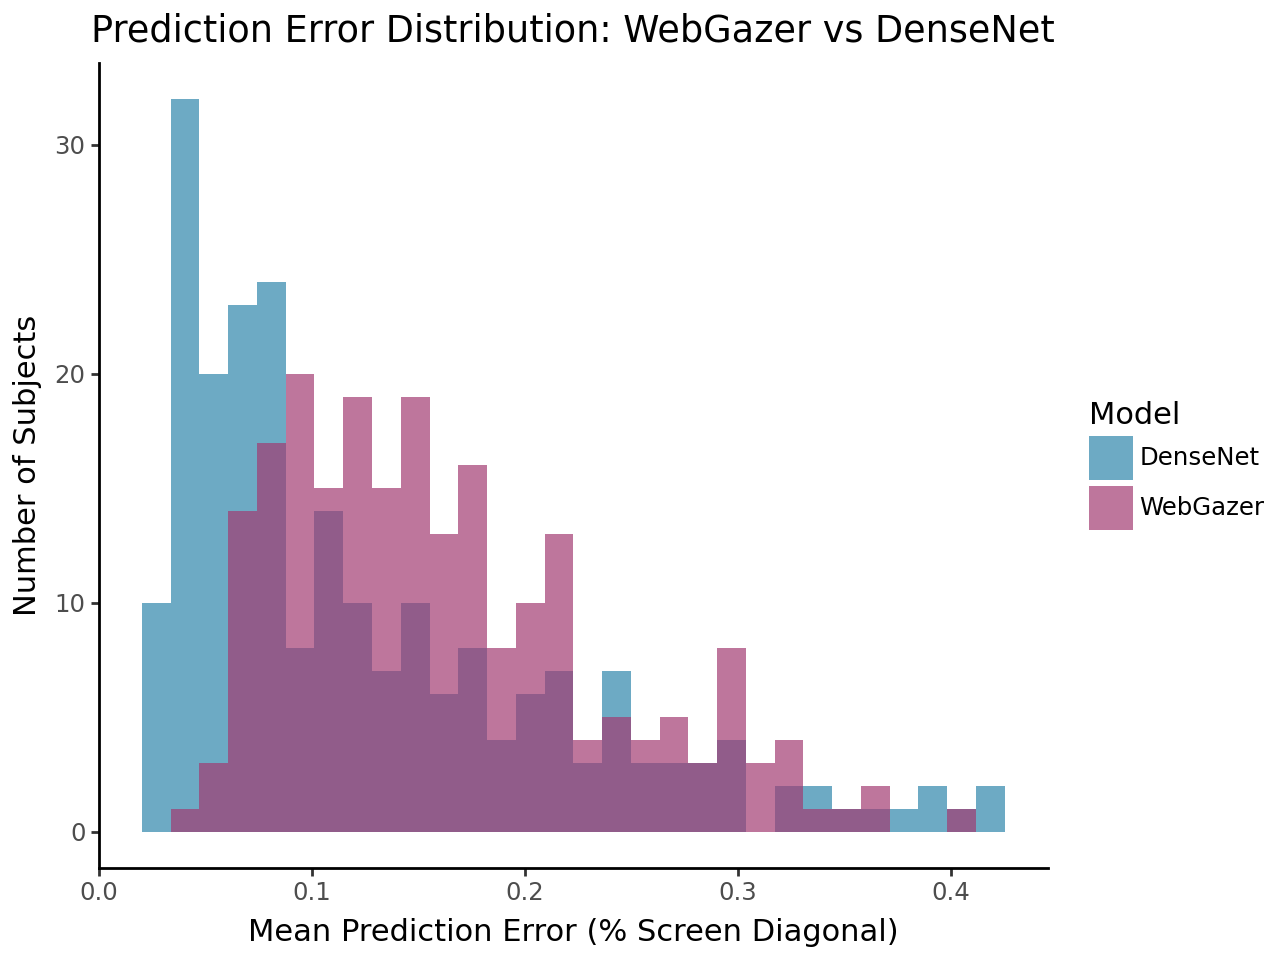

In [ ]:
# Create comparison visualizations

# 1. Error distribution comparison
distribution_plot = (
    ggplot(all_results, aes(x='mean_error', fill='model'))
    + geom_histogram(alpha=0.7, position='identity', bins=30)
    + labs(
        title='Prediction Error Distribution: WebGazer vs DenseNet',
        x='Mean Prediction Error (% Screen Diagonal)',
        y='Number of Subjects'
    )
    + scale_fill_manual(values=['#2E86AB', '#A23B72'], name='Model')
    + theme_classic()
    + theme(plot_title=element_text(hjust=0.5))
)

print("Distribution plot:")
distribution_plot

Scatter plot comparison:
Our model performed better than WebGazer in 185 subjects (82.58928571428571%)
Average improvement over WebGazer: 3.53%


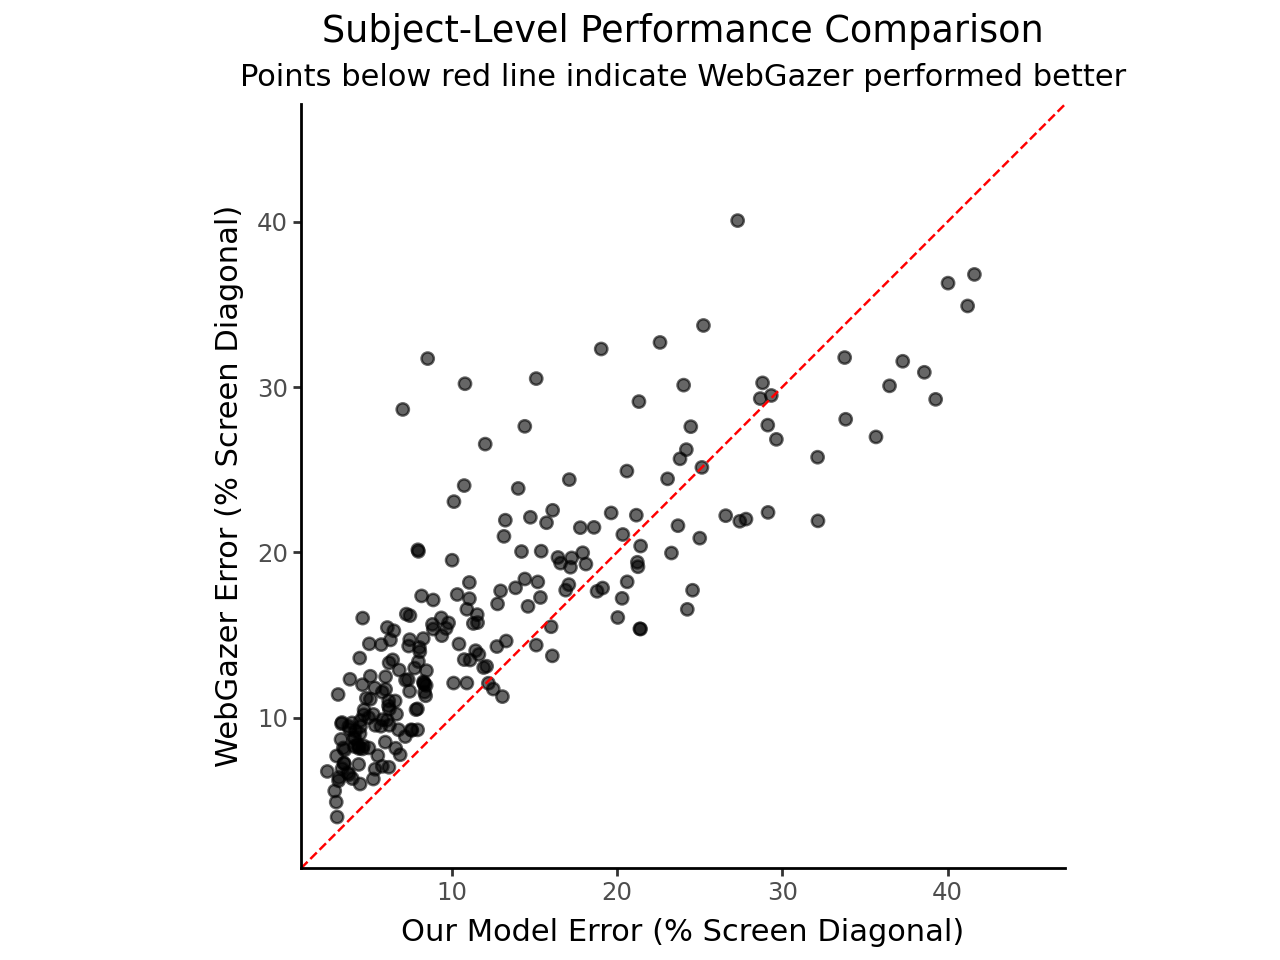

In [ ]:
from plotnine import coord_equal
# 2. Direct comparison scatter plot (for common subjects)

comparison_data = []
for subject_id in common_subjects:
    webgazer_error = webgazer_results[webgazer_results['subject_id'] == subject_id]['mean_error'].iloc[0]
    densenet_error = densenet_results[densenet_results['subject_id'] == subject_id]['mean_error'].iloc[0]

    comparison_data.append({
        'subject_id': subject_id,
        'webgazer_error': webgazer_error*100,
        'densenet_error': densenet_error*100,
        'difference': webgazer_error - densenet_error
    })

comparison_df = pd.DataFrame(comparison_data)

# Scatter plot
scatter_plot = (
    ggplot(comparison_df, aes(x='densenet_error', y='webgazer_error'))
    + geom_point(alpha=0.6, size=2)
    + geom_abline(intercept=0, slope=1, linetype='dashed', color='red')
    + labs(
        title='Subject-Level Performance Comparison',
        x='Our Model Error (% Screen Diagonal)',
        y='WebGazer Error (% Screen Diagonal)',
        subtitle='Points below red line indicate WebGazer performed better'
    )
    + coord_equal(xlim=(3, 45), ylim=(3, 45))
    + theme_classic()
    + theme(plot_title=element_text(hjust=0.5), plot_subtitle=element_text(hjust=0.5))
)

print("Scatter plot comparison:")

our_model_better = sum(comparison_df['difference'] > 0)
percent_better = (our_model_better / len(comparison_df)) * 100

print(f"Our model performed better than WebGazer in {our_model_better} subjects ({percent_better}%)")

avergage_improvement = comparison_df['difference'].mean() * 100
print(f"Average improvement over WebGazer: {avergage_improvement:.2f}%")

scatter_plot

## Save Results and Create Summary

In [ ]:
# Save plots
distribution_plot.save('webgazer_comparison_distribution.png', width=10, height=6, dpi=150)
box_plot.save('webgazer_comparison_boxplot.png', width=8, height=6, dpi=150)

if len(common_subjects) > 10:
    scatter_plot.save('webgazer_comparison_scatter.png', width=8, height=6, dpi=150)

# Save results data
all_results.to_csv('webgazer_densenet_comparison_results.csv', index=False)

if len(common_subjects) > 10:
    comparison_df.to_csv('webgazer_densenet_paired_comparison.csv', index=False)

print("Results and plots saved successfully")

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: webgazer_comparison_distribution.png
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 6 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: webgazer_comparison_boxplot.png
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 6 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: webgazer_comparison_scatter.png


Results and plots saved successfully
